# **Final Project - Group 3**
## **"Self-Driving Car"**
Implementing end-to-end learning for self-driving cars using simulator based on Nvidia Paper

In [4]:
#mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

#unzip data from drive

!unzip drive/MyDrive/Classroom/Brainster/IMG.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/IMG/right_2021_07_13_22_38_52_665.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_52_754.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_52_845.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_52_934.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_024.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_113.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_206.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_294.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_385.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_472.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_563.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_653.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_740.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_829.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_921.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_54_008.jpg  
  inflating: data/IMG

# **Importing Libraries**

In [6]:
import numpy as np
import pandas as pd
import os
import cv2 as cv 
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
import random
from sklearn.utils import shuffle
import tensorflow as tf
from random import shuffle
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import core, convolutional, pooling
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers, backend

# **Dataset loading, reading and preprocessing**

### Dataset load

In [7]:
#Dataset read

dataset = pd.read_csv('data/driving_log.csv', names= ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])
print(dataset['center'][0])

D:\simulacii\IMG\center_2021_07_13_22_33_52_335.jpg


In [9]:
#Extracting the image name path

copy_dataset = dataset.copy()

copy_dataset['center'] = copy_dataset['center'].apply(lambda x : x.split('\\')[3])
copy_dataset['left'] = copy_dataset['left'].apply(lambda x : x.split('\\')[3])
copy_dataset['right'] = copy_dataset['right'].apply(lambda x : x.split('\\')[3])

In [10]:
copy_dataset.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_07_13_22_33_52_335.jpg,left_2021_07_13_22_33_52_335.jpg,right_2021_07_13_22_33_52_335.jpg,0.0,0.0,0,0.000007
1,center_2021_07_13_22_33_52_434.jpg,left_2021_07_13_22_33_52_434.jpg,right_2021_07_13_22_33_52_434.jpg,0.0,0.0,0,0.000010
2,center_2021_07_13_22_33_52_527.jpg,left_2021_07_13_22_33_52_527.jpg,right_2021_07_13_22_33_52_527.jpg,0.0,0.0,0,0.000007
3,center_2021_07_13_22_33_52_595.jpg,left_2021_07_13_22_33_52_595.jpg,right_2021_07_13_22_33_52_595.jpg,0.0,0.0,0,0.000009
4,center_2021_07_13_22_33_52_691.jpg,left_2021_07_13_22_33_52_691.jpg,right_2021_07_13_22_33_52_691.jpg,0.0,0.0,0,0.000007


## Dataset read

In [11]:
#Definition of read_image function

def read_image(path_):
  """
  Reads image path and returns image in RGB format
  """
  final_path = os.path.join("data/IMG", path_)
  picture = cv.imread(final_path)
  picture_rgb = cv.cvtColor(picture, cv.COLOR_BGR2RGB)
  return picture_rgb

#Define inputs(image) and targets(angle) datasets and implementing read_image function

inputs = []
targets = []
for c1, c2, c3, angle in zip(copy_dataset['center'], copy_dataset['left'], copy_dataset['right'], copy_dataset['steering']):
   inputs.append(c1)
   targets.append(angle)
   inputs.append(c2)
   targets.append(angle-0.2)
   inputs.append(c3)
   targets.append(angle+0.2)

print(len(inputs))
print(len(targets))

26037
26037


Training Samples: 20829
Test Samples: 5208


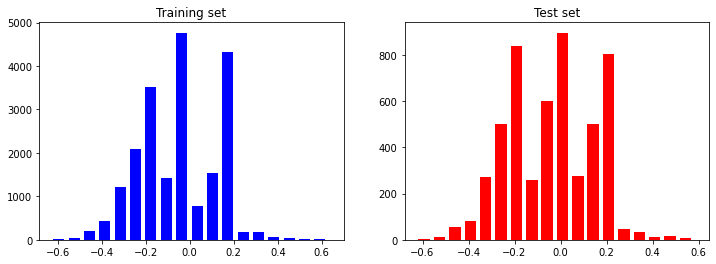

In [12]:
#Dataset split

X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size = 0.20, random_state = 1)

# Check that data is valid
print("Training Samples: {}\nTest Samples: {}".format(len(X_train), len(X_test)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=18, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_test, bins=18, width=0.05, color='red')
axes[1].set_title('Test set');

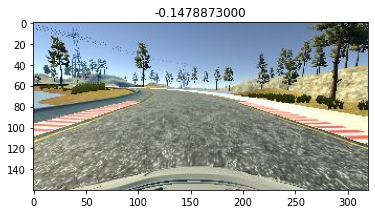

In [13]:
plt.imshow(read_image(X_train[10]))
plt.title('{0:.10f}'.format(y_train[10]))
plt.show()

## Dataset preprocessing

In [14]:
#Definition of crop function

def crop(img, crop_size=60):
    """
    Crop the image (removing the sky)
    """
    new_slika = img.copy()
    cropped = new_slika[crop_size:, :, :]

    return cropped

In [15]:
#Definition of resize function

image_width = 200
image_height = 66

def resize_image(image):
    """
    Resize the image to the input shape used by the network model
    """
    resized_image = cv.resize(image, (image_width, image_height), cv.INTER_AREA)
    
    return resized_image


In [16]:
#YUV color transformation function

def yuv_color(image):
  """ 
  Change to YUV image
  """
  yuv_image = cv.cvtColor(image, cv.COLOR_RGB2YUV)

  return yuv_image

In [17]:
#Normalize data 

def normalize(image):
  image = image.astype(np.float32)
  return image/255.0

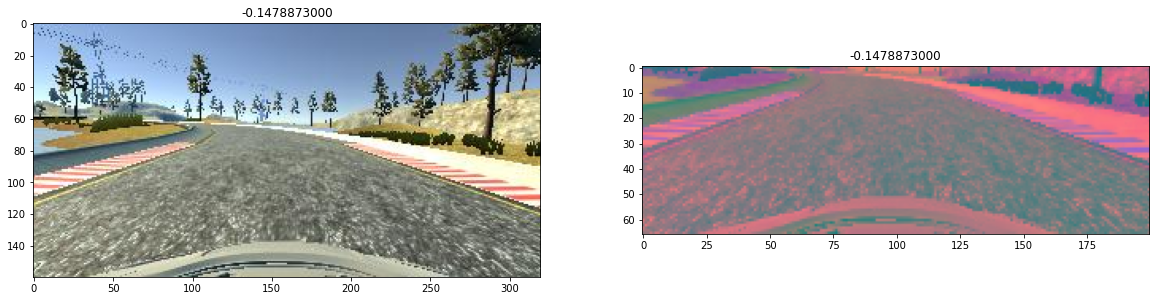

In [18]:
#Comparison of the original and the cropped image

f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(X_train[10]))
plt.title('{0:.10f}'.format(y_train[10]))
f.add_subplot(1,2, 2)
plt.imshow(yuv_color(resize_image(crop(read_image(X_train[10])))))
plt.title('{0:.10f}'.format(y_train[10]))
plt.show(block=True)

# **Defining Image Augmentation Functions**



In [21]:
#Image flip function

def flip_image(img, steering_angle):
    """
    Flip the image and adjust the steering angle.
    """
    flip_img = cv.flip(img, 1)
    steering_angle = steering_angle * (-1)
    return flip_img, steering_angle

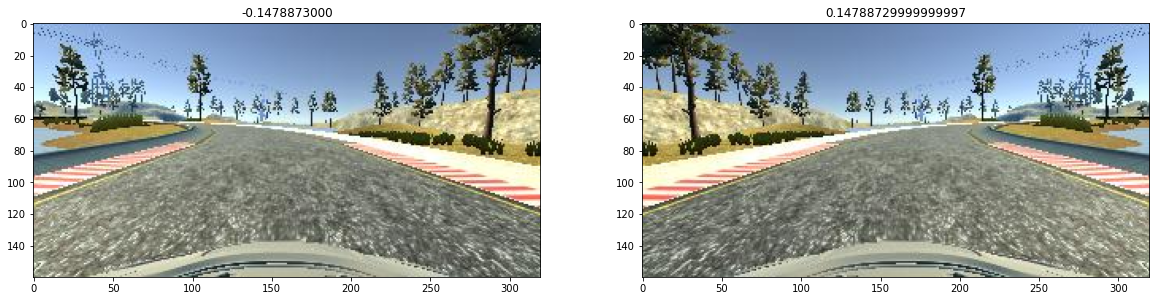

In [22]:
#Comparison of the original and the flipped image

original_image = read_image(X_train[10])
original_angle = y_train[10]

fliped_image, fliped_angle = flip_image(original_image, original_angle)

f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(X_train[10]))
plt.title('{0:.10f}'.format(y_train[10]))
f.add_subplot(1,2, 2)
plt.imshow(fliped_image)
plt.title(fliped_angle)

plt.show(block=True)

In [23]:
#Changing brigthness of image

def change_image_brightness(img, s_low=0.3, s_high=0.7):
    """
    Adjust brightness of the image.
    """
    img = img.astype(np.float32)
    s = np.random.uniform(s_low, s_high)
    img[:,:,:] *= s
    np.clip(img, 0, 255)
    return  img.astype(np.uint8)

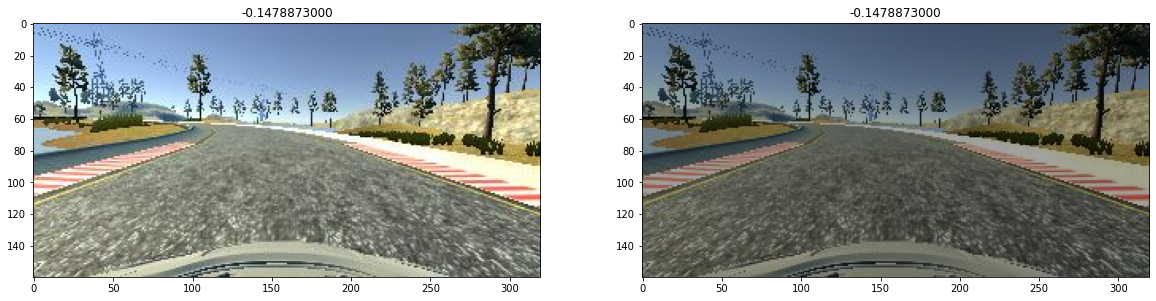

In [24]:
#Comparison of the original and image with changed brigthness

f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(X_train[10]))
plt.title('{0:.10f}'.format(y_train[10]))
f.add_subplot(1,2, 2)
plt.imshow(change_image_brightness(read_image(X_train[10])))
plt.title('{0:.10f}'.format(y_train[10]))
plt.show(block=True)

In [25]:
#Adding random shadow

def add_random_shadow(img, w_low=0.5, w_high=0.9):
    """
    Generates and adds random shadow.
    """
    cols, rows = (img.shape[0], img.shape[1])
    
    top_y = np.random.random_sample() * rows
    bottom_y = np.random.random_sample() * rows
    bottom_y_right = bottom_y + np.random.random_sample() * (rows - bottom_y)
    top_y_right = top_y + np.random.random_sample() * (rows - top_y)
    if np.random.random_sample() <= 0.5:
        bottom_y_right = bottom_y - np.random.random_sample() * (bottom_y)
        top_y_right = top_y - np.random.random_sample() * (top_y)
    
    poly = np.asarray([[ [top_y,0], [bottom_y, cols], [bottom_y_right, cols], [top_y_right,0]]], dtype=np.int32)
        
    mask_weight = np.random.uniform(w_low, w_high)
    origin_weight = 1 - mask_weight
    
    mask = np.copy(img).astype(np.int32)
    cv.fillPoly(mask, poly, (0, 0, 0))
    
    return cv.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)

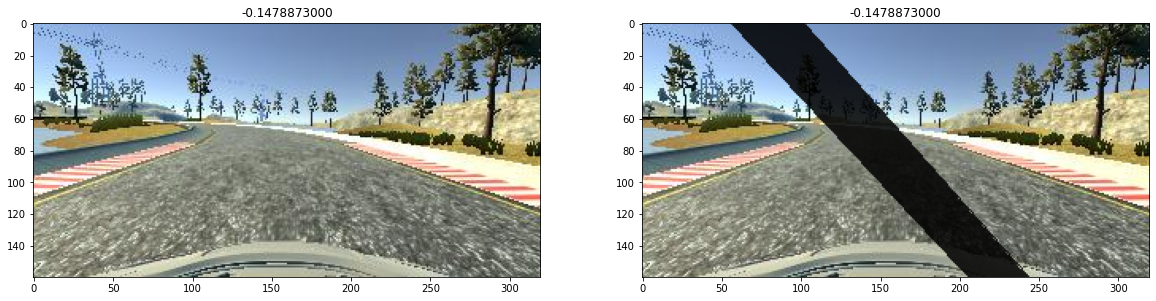

In [26]:
#Comparison of the original and image with added random shadow

f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(X_train[10]))
plt.title('{0:.10f}'.format(y_train[10]))
f.add_subplot(1,2, 2)
plt.imshow(add_random_shadow(read_image(X_train[10])))
plt.title('{0:.10f}'.format(y_train[10]))
plt.show(block=True)

In [27]:
#Adding random noise

def random_noise(image,prob=0.05):
    """
    Adds random noise to teh image.
    """
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

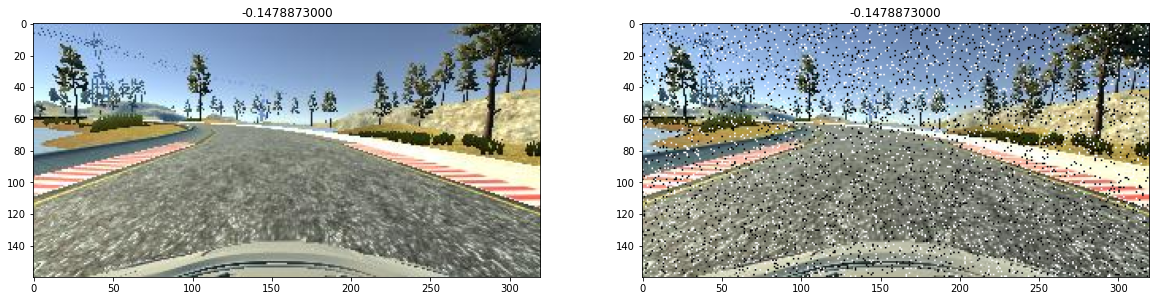

In [28]:
#Comparison of the original and image with added random noise

f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(X_train[10]))
plt.title('{0:.10f}'.format(y_train[10]))
f.add_subplot(1,2, 2)
plt.imshow(random_noise(read_image(X_train[10])))
plt.title('{0:.10f}'.format(y_train[10]))
plt.show(block=True)

# **Generator**

In [29]:
def augment_image(img, angle, p=1.0):
    """
    Randomly implements augmention function on image.
    """
    aug_img = img
    
    if np.random.random_sample() <= p: 
        aug_img, angle = flip_image(aug_img, angle)
     
    if np.random.random_sample() <= p:
        aug_img = change_image_brightness(aug_img)
    
    if np.random.random_sample() <= p: 
        aug_img = add_random_shadow(aug_img)

    if np.random.random_sample() <= p:
        aug_img = random_noise(aug_img)
            
    return aug_img, angle

In [30]:
def generator(inputs, targets, batch_size = 32, is_training=True):
    """
    Creating 'generator' function for memory efficiency.
    This function shuffles the dataset, crops images, randomly implements image agmentation function only on training dataset and normalize the images.
    """
    images = inputs

    while True:
      images, targets = sklearn.utils.shuffle(images, targets)
      for i in range(0, len(images), batch_size):
          X_batch = []
          target_batch  = []
          for image, target in zip(images[i:i+batch_size], targets[i:i+batch_size]):
              #Read, crop, resize and yuv color 
              slika = read_image(image)
              slika = crop(slika)
              slika = resize_image(slika)
              if is_training:
                slika = yuv_color(slika)
                X_batch.append(normalize(slika))
                target_batch.append(target)
                fliped_image, angle = flip_image(normalize(slika), target)
                X_batch.append(fliped_image)
                target_batch.append(angle)
                slika, target = augment_image(normalize(slika), target, p=0.5)
              else:
                X_batch.append(normalize(slika))
                target_batch.append(target)
          yield np.array(X_batch), np.array(target_batch)

In [31]:
train_generator = generator(X_train, y_train, 32)
valid_generator = generator(X_test, y_test, 32, is_training=False)

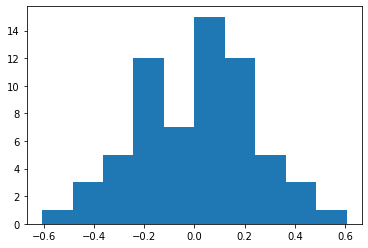

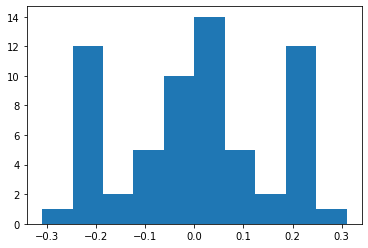

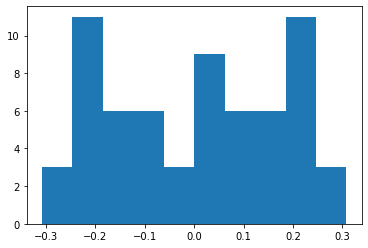

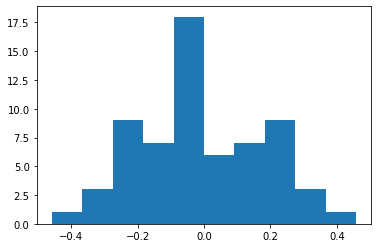

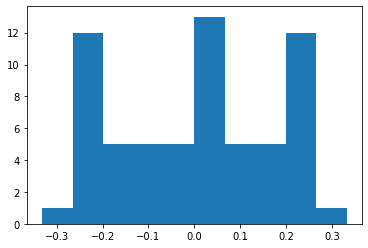

In [32]:
#Visualzation of target per batch

for i in range(5):
   _, angle = next(train_generator)
   plt.hist(angle, bins = 10)
   plt.show()

# **Building Neural Networks**

##Model 1 architecture, compile, summary

In [ ]:
model1 = Sequential()

# Input normalization layer
model1.add(Convolution2D(16, (3, 3), strides = (2, 2), input_shape=(image_height, image_width, 3), activation='relu'))

model1.add(Convolution2D(32, 3, 3, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model1.add(Convolution2D(64, 2, 2, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model1.add(core.Flatten())

model1.add(core.Dense(100, activation='relu'))
model1.add(core.Dropout(.5))

model1.add(core.Dense(64, activation='relu'))
model1.add(core.Dropout(.25))

model1.add(core.Dense(10, activation='relu'))

model1.add(core.Dense(1))

#model compile
model1.compile(optimizer=optimizers.Adam(learning_rate=1e-04), loss='mse')

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 99, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 33, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 17, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               2

###Model checkpoint and early stopping

In [ ]:
callback1 = ModelCheckpoint('best_model1.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback2 = EarlyStopping(patience=10)
callback_list = [callback1, callback2]

###Model training

In [ ]:
history = model1.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list,
        epochs=30)

Epoch 1/30


KeyboardInterrupt: ignored

###Model resaults visualization

Text(0.5, 0, 'Epoch')

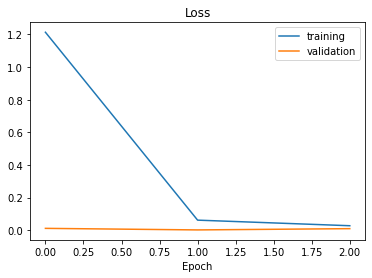

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

###Model save

In [ ]:
model1.save('model1.h5')

##Model 2 architecture, compile, summary

In [ ]:
model2 = Sequential()
# Input normalization layer
model2.add(Convolution2D(24, 2, 2, input_shape=(image_height, image_width, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model2.add(Convolution2D(36, 2, 2, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model2.add(Convolution2D(48, 2, 2, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model2.add(Convolution2D(64, 1, 1, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model2.add(Dropout(0.5))

model2.add(Convolution2D(128, 1, 1, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model2.add(Dropout(0.5))

model2.add(core.Flatten())
model2.add(core.Dense(100, activation='relu'))
model2.add(core.Dropout(0.25))

model2.add(core.Dense(50, activation='relu'))
model2.add(core.Dropout(0.25))

model2.add(core.Dense(10, activation='relu'))

model2.add(core.Dense(1))

#model compile
model2.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='mse')

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 33, 100, 24)       312       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 50, 24)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 25, 36)         3492      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 13, 36)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 6, 48)          6960      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 3, 48)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 3, 64)         

###Model checkpoint and early stopping

In [ ]:
callback12 = ModelCheckpoint('best_model2.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback22 = EarlyStopping(patience=15)
callback_list_2 = [callback12, callback22]

###Model training

In [ ]:
history_2 = model2.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list_2,
        epochs=60)

Epoch 1/60
650/650 [==============================] - 291s 423ms/step - loss: 11.8479 - val_loss: 0.0350

Epoch 00001: val_loss improved from inf to 0.03496, saving model to best_model2.pt
INFO:tensorflow:Assets written to: best_model2.pt/assets
Epoch 2/60
650/650 [==============================] - 275s 424ms/step - loss: 0.0396 - val_loss: 0.0348

Epoch 00002: val_loss improved from 0.03496 to 0.03478, saving model to best_model2.pt
INFO:tensorflow:Assets written to: best_model2.pt/assets
Epoch 3/60
650/650 [==============================] - 272s 419ms/step - loss: 0.0360 - val_loss: 0.0346

Epoch 00003: val_loss improved from 0.03478 to 0.03460, saving model to best_model2.pt
INFO:tensorflow:Assets written to: best_model2.pt/assets
Epoch 4/60
650/650 [==============================] - 276s 425ms/step - loss: 0.0350 - val_loss: 0.0344

Epoch 00004: val_loss improved from 0.03460 to 0.03443, saving model to best_model2.pt
INFO:tensorflow:Assets written to: best_model2.pt/assets
Epoch 5

###Model results visualization

Text(0.5, 0, 'Epoch')

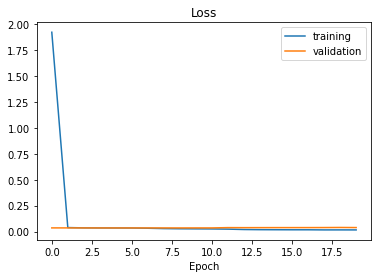

In [ ]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

###Model save

In [ ]:
model2.save('model2.h5')

##Model 3 architecture, compile, summary

In [ ]:
model3 = Sequential()
model3.add(Convolution2D (64, 3, 3, input_shape=(image_height, image_width, 3), padding ='same', activation='elu'))
model3.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))

model3.add(Convolution2D (128, 3, 3, padding ='same', activation='elu'))
model3.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))

model3.add(Convolution2D (256, 3, 3, padding ='same', activation='elu'))
model3.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))

model3.add(Convolution2D (512, 3, 3, padding ='same', activation='elu'))
model3.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model3.add(Dropout(0.5))

model3.add(Flatten())

model3.add(Dense(256, activation ='elu'))
model3.add(Dropout(0.5))

model3.add(Dense(64, activation ='elu'))
model3.add(Dropout(0.5))

model3.add(Dense(1))

model3.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='mse')

In [ ]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 22, 67, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 34, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 12, 128)        73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 6, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 2, 256)         295168    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 512)        

###Model checkpoint and early stopping

In [ ]:
callback13 = ModelCheckpoint('best_model_3.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback23 = EarlyStopping(patience=15)
callback_list_3 = [callback13, callback23]

###Model training

In [ ]:
history_3 = model3.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list_3,
        epochs=60)

Epoch 1/60
650/650 [==============================] - 393s 587ms/step - loss: 1.7385 - val_loss: 0.0236

Epoch 00001: val_loss improved from inf to 0.02356, saving model to best_model_3.pt
INFO:tensorflow:Assets written to: best_model_3.pt/assets
Epoch 2/60
650/650 [==============================] - 381s 587ms/step - loss: 0.1027 - val_loss: 0.0122

Epoch 00002: val_loss improved from 0.02356 to 0.01219, saving model to best_model_3.pt
INFO:tensorflow:Assets written to: best_model_3.pt/assets
Epoch 3/60
650/650 [==============================] - 378s 581ms/step - loss: 0.0578 - val_loss: 0.0131

Epoch 00003: val_loss did not improve from 0.01219
Epoch 4/60
650/650 [==============================] - 376s 579ms/step - loss: 0.0381 - val_loss: 0.0146

Epoch 00004: val_loss did not improve from 0.01219
Epoch 5/60
650/650 [==============================] - 379s 583ms/step - loss: 0.0235 - val_loss: 0.0183

Epoch 00005: val_loss did not improve from 0.01219
Epoch 6/60
650/650 [==============

###Model results visualization

Text(0.5, 0, 'Epoch')

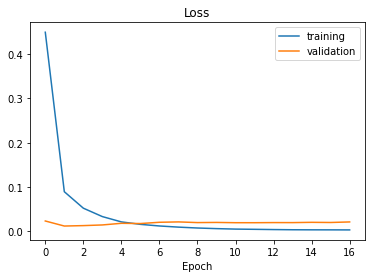

In [ ]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

###Model save

In [ ]:
model3.save('model3.h5')

##Model 4 architecture, compile and summary

In [87]:
model4 = Sequential()
model4.add(Convolution2D(24, 5, 5, input_shape = (image_height,image_width,3), activation='relu'))
model4.add(BatchNormalization())

model4.add(Convolution2D(36, 5, 5, activation='relu'))
model4.add(BatchNormalization())

model4.add(Convolution2D(64, 2, 2, activation='relu'))
model4.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model4.add(BatchNormalization())

model4.add(Convolution2D(128, 1, 1, activation='relu'))
model4.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model4.add(BatchNormalization())

model4.add(Convolution2D(256, 1, 1, activation='relu'))
model4.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model4.add(BatchNormalization())

model4.add(Convolution2D(512, 1, 1, activation='relu'))
model4.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model4.add(BatchNormalization())
#model4.add(Dropout(0.5))
    
model4.add(Flatten())

model4.add(Dense(250, activation='relu'))
model4.add(BatchNormalization())

model4.add(Dense(100, activation='relu'))
model4.add(BatchNormalization())

model4.add(Dense(50, activation='relu'))
model4.add(BatchNormalization())
    
model4.add(Dense(10, activation='relu'))
model4.add(BatchNormalization())
    
model4.add(Dense(1))
    
model4.compile(loss = "MSE", optimizer = Adam(learning_rate = 0.001))

In [88]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 13, 40, 24)        1824      
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 40, 24)        96        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 2, 8, 36)          21636     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 8, 36)          144       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 1, 4, 64)          9280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 2, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 2, 64)         

In [91]:
callback14 = ModelCheckpoint('best_model_4.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback24 = EarlyStopping(patience=10)
callback_list_4 = [callback14, callback24]

In [1]:
history_4 = model4.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list_4,
        epochs=30)

NameError: ignored

Text(0.5, 0, 'Epoch')

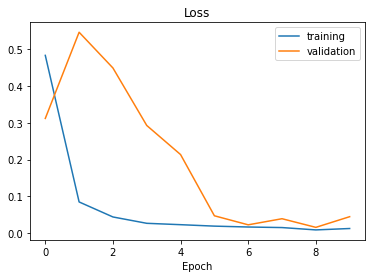

In [ ]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model4.save('model4.h5')

##Model 

In [33]:
model5 = Sequential()
# Input normalization layer
model5.add(Convolution2D(24, (5, 5), strides = (2, 2), input_shape = (66, 200, 3), activation = 'elu'))

# 5x5 Convolutional layers with stride of 2x2
model5.add(Convolution2D(24, (5, 5), strides=(2, 2), activation='elu'))
model5.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
model5.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))

# 3x3 Convolutional layers with stride of 1x1
model5.add(Convolution2D(64, (1, 1), strides=(1, 1), activation='elu'))
model5.add(Convolution2D(64, (1, 1), strides=(1, 1), activation='elu'))

# Flatten before passing to Fully Connected layers
model5.add(Flatten())

# Three fully connected layers
model5.add(Dense(100, activation='elu'))
model5.add(Dropout(.5))
model5.add(Dense(50, activation='elu'))
model5.add(Dropout(.5))
model5.add(Dense(10, activation='elu'))
model5.add(Dropout(.5))

# Output layer with tanh activation 
model5.add(Dense(1))

adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model5.compile(optimizer="adam", loss="mse")


In [34]:
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 24)        14424     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 36)         21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 9, 48)          43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 9, 64)          3136      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 9, 64)          4160      
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

In [36]:
callback15 = ModelCheckpoint('best_model_5.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback25 = EarlyStopping(patience=10)
callback_list_5 = [callback15, callback25]

In [ ]:
history_5 = model5.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list_5,
        epochs=30)

Epoch 1/30
650/650 [==============================] - 456s 678ms/step - loss: 0.0474 - val_loss: 0.0337

Epoch 00001: val_loss improved from inf to 0.03369, saving model to best_model_5.pt
INFO:tensorflow:Assets written to: best_model_5.pt/assets
Epoch 2/30
650/650 [==============================] - 438s 673ms/step - loss: 0.0119 - val_loss: 0.0382

Epoch 00002: val_loss did not improve from 0.03369
Epoch 3/30
650/650 [==============================] - 430s 662ms/step - loss: 0.0098 - val_loss: 0.0294

Epoch 00003: val_loss improved from 0.03369 to 0.02937, saving model to best_model_5.pt
INFO:tensorflow:Assets written to: best_model_5.pt/assets
Epoch 4/30
622/650 [===========================>..] - ETA: 18s - loss: 0.0092

Text(0.5, 0, 'Epoch')

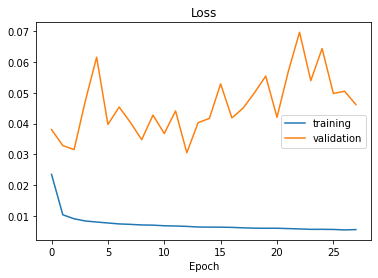

In [85]:
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [86]:
model5.save('model5.h5')

In [42]:
model6 = Sequential()
model6.add(Convolution2D(32, (3, 3), activation='relu', input_shape = (66, 200, 3), padding='same'))
model6.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model6.add(Dropout(0.25))
model6.add(Convolution2D(64, (3, 3), activation='relu', padding='same'))
model6.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model6.add(Dropout(0.25))
model6.add(Convolution2D(128, (3, 3), activation='relu', padding='same'))
model6.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model6.add(Dropout(0.5))
model6.add(Flatten())
model6.add(Dense(1024, activation='relu'))
model6.add(Dropout(0.5))
model6.add(Dense(1))
model6.compile(optimizer=Adam(learning_rate=1e-4), loss = 'mse')

In [43]:
model6.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 66, 200, 32)       896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 100, 32)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 33, 100, 32)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 100, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 50, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 17, 50, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 17, 50, 128)      

In [44]:
callback16 = ModelCheckpoint('best_model_6.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback26 = EarlyStopping(patience=15)
callback_list_6 = [callback16, callback26]

In [45]:
history_6 = model6.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list_6,
        epochs=50)

Epoch 1/50
650/650 [==============================] - 297s 388ms/step - loss: 1302.4833 - val_loss: 0.0357

Epoch 00001: val_loss improved from inf to 0.03569, saving model to best_model_6.pt
INFO:tensorflow:Assets written to: best_model_6.pt/assets
Epoch 2/50
650/650 [==============================] - 248s 381ms/step - loss: 0.2957 - val_loss: 0.0356

Epoch 00002: val_loss improved from 0.03569 to 0.03560, saving model to best_model_6.pt
INFO:tensorflow:Assets written to: best_model_6.pt/assets
Epoch 3/50
650/650 [==============================] - 246s 378ms/step - loss: 0.0462 - val_loss: 0.0357

Epoch 00003: val_loss did not improve from 0.03560
Epoch 4/50
650/650 [==============================] - 249s 384ms/step - loss: 0.0412 - val_loss: 0.0357

Epoch 00004: val_loss did not improve from 0.03560
Epoch 5/50
650/650 [==============================] - 249s 383ms/step - loss: 0.0372 - val_loss: 0.0356

Epoch 00005: val_loss did not improve from 0.03560
Epoch 6/50
650/650 [===========

KeyboardInterrupt: ignored

##Preparing the X_train dataset for predictions

In [ ]:
def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = read_image(image)
    image = crop(image)
    image = resize_image(image)
    image = normalize(image)

    return image

In [ ]:
# Converting the X_test dataset for predictions

X_test_ = np.array(list(map(preprocess, X_test)))

In [ ]:
mode1_prediction = model1.predict(X_test_)
mode2_prediction = model2.predict(X_test_)
mode3_prediction = model3.predict(X_test_)
mode4_prediction = model4.predict(X_test_)
mode5_prediction = model5.predict(X_test_)

In [ ]:
mode1_prediction = mode1_prediction.reshape(1,-1)
mode2_prediction = mode2_prediction.reshape(1,-1)
mode3_prediction = mode3_prediction.reshape(1,-1)
mode4_prediction = mode4_prediction.reshape(1,-1)
mode5_prediction = mode5_prediction.reshape(1,-1)

In [ ]:
model1_pred_abs = np.abs(y_test-mode1_prediction) 
model2_pred_abs = np.abs(y_test-mode2_prediction) 
model3_pred_abs = np.abs(y_test-mode3_prediction) 
model4_pred_abs = np.abs(y_test-mode4_prediction) 
model5_pred_abs = np.abs(y_test-mode5_prediction) 

In [ ]:
threshold = 0.7

In [ ]:
is_accurate_model1 = np.where(model1_pred_abs<threshold, 1, 0)
is_accurate_model2 = np.where(model2_pred_abs<threshold, 1, 0)
is_accurate_model3 = np.where(model3_pred_abs<threshold, 1, 0)
is_accurate_model4 = np.where(model4_pred_abs<threshold, 1, 0)
is_accurate_model5 = np.where(model5_pred_abs<threshold, 1, 0)

In [ ]:
accuracy_score_model1 = np.mean(is_accurate_model1)
accuracy_score_model2 = np.mean(is_accurate_model2)
accuracy_score_model3 = np.mean(is_accurate_model3)
accuracy_score_model4 = np.mean(is_accurate_model4)
accuracy_score_model5 = np.mean(is_accurate_model5)